In [170]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as c
from astropy.table import Table
import numpy as np
from matplotlib import colors
import lmfit
import glob
from lmfit.models import GaussianModel, SplineModel, PolynomialModel
import pandas as pd
from astropy.io import ascii
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Setting things up

In [2]:
cc = ['#f72585', '#7209b7', '#FFBC42', '#4361ee', '#4cc9f0']

In [3]:
def plot_data(obj,percentile = [1, 99],use_log = False):
    if(use_log):
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])),norm=colors.LogNorm())
    else:
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])))
    plt.colorbar()

def read_file(row):
    return fits.open(row['File'])['PRIMARY'].data.astype(float)

In [4]:
files = sorted(glob.glob("./20230507/*.fits"))

In [5]:
# slit width in arcsec
slit_w = 30 * u.arcsecond
# scale: 0.37 arcsec per pixel (supposedly)
scale = 0.37 * u.arcsecond
# divide but then add 20 because idk
slit_pixel_w = int(slit_w / scale) + 20
slit_pixel_w

101

In [6]:
# generate observation log
Obslog = Table(
                    names=("File", "Date", "UTC", "ra", "dec", "observer", "objid", "airmass", "exptime", "obstype"
                    ),
                    meta={"name": "Observation Log"},
                    dtype=("U64", "U64", "U64", "U64", "U64", "U64", "U64", "float64", "float64", "U64"
                          )
                    )
for i in files:
      open_file = fits.open(i)
      header_file = open_file[0].header
      row = [i, header_file["DATE"], header_file["TIME"], header_file["RA"],
             header_file["DEC"], header_file["OBSERVER"], header_file["OBJECT"], 
             header_file["AIRMASS"], header_file["EXPTIME"], header_file["OBSTYPE"]]
      Obslog.add_row(row)
Obslog

File,Date,UTC,ra,dec,observer,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,str64,float64,float64,str64
./20230507/image0001.fits,126,23:32:08.2,06:41:18.93,+33:31:29.1,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507/image0002.fits,126,23:33:31.8,06:42:42.78,+33:31:31.9,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507/image0003.fits,126,23:34:19.6,06:43:30.72,+33:31:33.4,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507/image0004.fits,126,23:35:08.4,06:44:19.66,+33:31:35.0,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507/image0005.fits,126,23:35:57.2,06:45:08.59,+33:31:36.6,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507/image0006.fits,126,23:36:46.0,06:45:57.55,+33:31:38.2,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507/image0007.fits,126,23:37:34.9,06:46:46.58,+33:31:39.8,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507/image0008.fits,126,23:38:23.7,06:47:35.53,+33:31:41.4,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507/image0009.fits,126,23:39:12.5,06:48:24.46,+33:31:43.0,xanderberylcarlos,lampon,1.0,45.0,flat


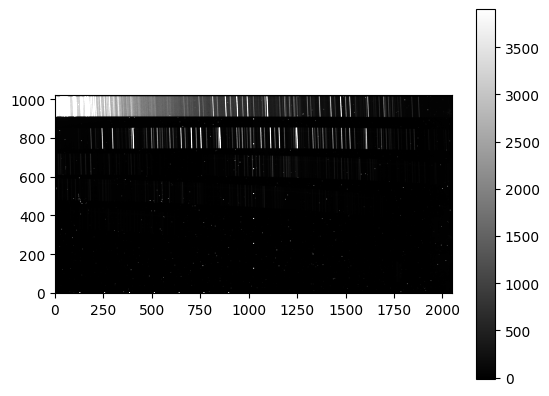

In [7]:
# our data
xb_data = Obslog[np.where("xanderberyl" == Obslog["observer"])]
# flat data
flat_table = Obslog[np.where("flat" == Obslog["obstype"])]
# standard star data
standard = Obslog[np.where("HD 162208" == Obslog["objid"])]

# Plot one of our images to test
plot_data(read_file(xb_data[0]))

# Creating the master flat

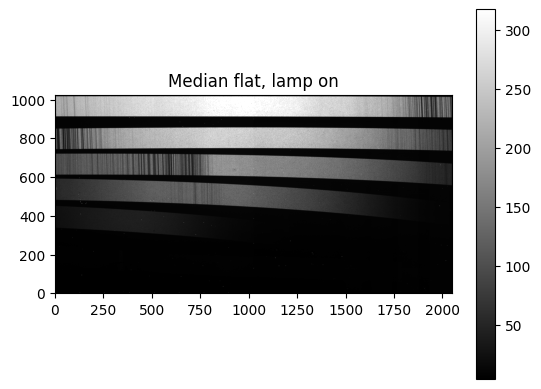

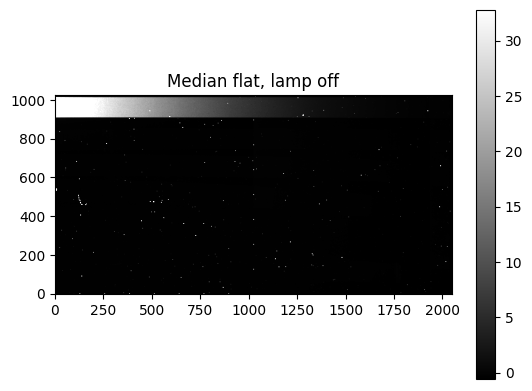

1.215775935981709


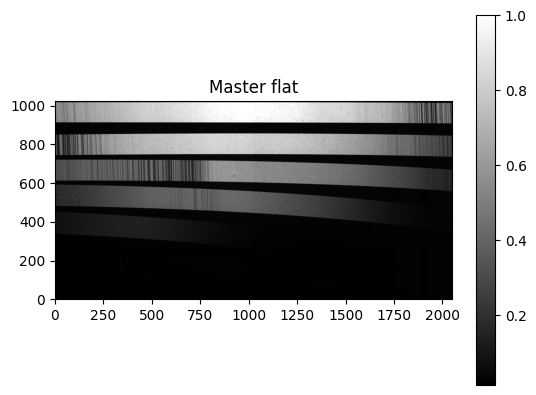

In [8]:
# flats with the lamp on
flat_table_on = flat_table[np.where("lampon" == flat_table["objid"])]
# get median of all on flats
flat_data_on = np.array([read_file(i) / i["exptime"] for i in flat_table_on])
flat_on = np.median(flat_data_on, axis=0)
plot_data(flat_on)
plt.title('Median flat, lamp on')
plt.show()

# flats with the lamp off
flat_table_off = flat_table[np.where("lampoff" == flat_table["objid"])]
# get median of all off flats
flat_data_off = np.array([read_file(i) / i["exptime"] for i in flat_table_off])
flat_off = np.median(flat_data_off, axis=0)
plot_data(flat_off)
plt.title('Median flat, lamp off')
plt.show()

# subtract off from on
flat_counts = flat_on - flat_off
# normalize to get the master flat
flat = flat_counts / np.percentile(flat_counts, 99)
print(np.max(flat))
plot_data(flat)
plt.title('Master flat')
plt.show()

# like read_file but then it divides by the master flat
def read_file_flat(row, f=flat):
    '''row should be in the form ObsLog[i]'''
    im = read_file(row)/row['exptime']
    im /= f
    return im

# Defining all the functions for extracting the spectrum

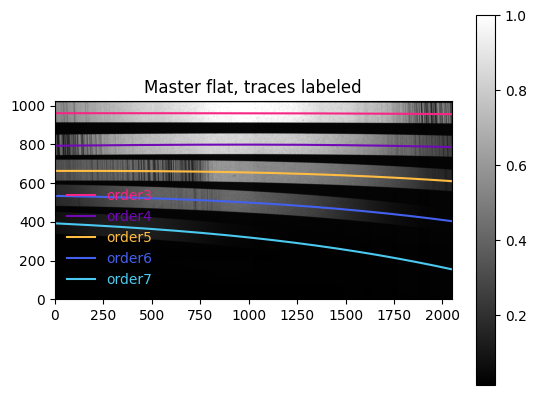

In [9]:
# get the trace from the file zach sent
trace = np.flip(Table.from_pandas(pd.read_csv("tspec_traces.csv")))

# display the master flat with trace labeled
plot_data(flat)
for i, order in enumerate(['order3', 'order4', 'order5', 'order6', 'order7']):
    plt.plot(range(2048), trace[order], label=order, c=cc[i])
plt.legend(frameon=False, labelcolor='linecolor')
plt.title('Master flat, traces labeled')
plt.show()

In [10]:
# function to rectify all an order (can be 3-7)
def rectify(data, order, trace=trace, slit_w=slit_pixel_w, offset=0):
    '''Rectifies an order of some frame'''
    # construct string for which order we are using
    order = "order" + str(order)
    # get the trace from the file
    trace_order = trace[order]
    # bottom pixel coordinates of the order
    trace_line_min = np.floor(trace_order - slit_w/2).astype(int)
    # top pixel coordinates of the order
    trace_line_max = trace_line_min + slit_w + offset
    # rectify each column
    rectified = np.zeros([len(data), int(slit_w)])
    for i, column in enumerate(data):
        rectified[i] = column[trace_line_min[i]:trace_line_max[i]]
    return rectified.T

def rectify_ccd(data, trace=trace, slit_w=slit_pixel_w, offset=0):
    '''Applies the rectify function to each order in the frame'''
    data_dict = {}
    for order in range(3,8):
        data_dict[order] = (rectify(data, order, trace, slit_w, offset))
    return data_dict

def rectify_array(data_array, trace=trace, slit_w=slit_pixel_w, offset=0):
    '''Applies the rectify_ccd function to each frame in an array'''
    return np.array([rectify_ccd(data, trace, slit_w, offset) for data in data_array])

In [11]:
def gauss(x, a, mu, sigma, c):
    return a * np.exp(-0.5*((x-mu)/sigma)**2) + c

In [12]:
def find_trace(im, plot=False):
    # take a horizontal sum
    sum_im = np.nanmedian(im, axis=1)
    sum_im = sum_im - np.nanmedian(sum_im)
    # fit a Gaussian to the data
    popt, _ = curve_fit(gauss, np.arange(len(sum_im)), sum_im,
                    p0=[np.nanmax(sum_im), np.nanargmax(sum_im), 5, 0])
    
    if plot:
        plot_data(im)
        plt.axhline(popt[1] - 9*popt[2], c='orange', lw=0.8)
        plt.axhline(popt[1] - 3*popt[2], c='orange', lw=0.8)
        plt.axhline(popt[1] + 3*popt[2], c='orange', lw=0.8)
        plt.axhline(popt[1] + 9*popt[2], c='orange', lw=0.8)
        plt.show()
        
        plt.plot(np.arange(len(sum_im)), sum_im, c='c', label='data')
        plt.plot(np.arange(len(sum_im)), gauss(np.arange(len(sum_im)), *popt), 'k--', label='Gaussian fit')
        plt.axvline(popt[1] - 3*popt[2], c='orange', label='3 sigma from center')
        plt.axvline(popt[1] + 3*popt[2], c='orange')
        plt.legend(frameon=False)
        plt.show()
    
    # return center and 1 sigma
    return popt[1], popt[2]

In [13]:
def extract_spec(im, tcenter, tsigma, plot=False):
    
    # get signal
    im_signal = im[int(tcenter-3*tsigma):int(tcenter+3*tsigma)]
    # sum to get the spectrum
    signal = np.sum(im_signal, axis=0)
    
    # background is between 3 to 9 sigma above and below aperture
    im_back_below = im[int(tcenter-9*tsigma):int(tcenter-3*tsigma)]
    im_back_above = im[int(tcenter+3*tsigma):int(tcenter+9*tsigma)]
    im_background = np.concatenate((im_back_below, im_back_above), axis=0)
    # median to get the background signal
    background = np.median(im_background, axis=0)
    # multiply by number of rows in im_signal
    background *= len(im_signal)    
    # subtract background from signal
    spec = signal - background
    
    if plot:
        plt.plot(signal, c=cc[0], label='signal')
        plt.plot(background, c=cc[1], label='background')
        plt.plot(spec, c=cc[2], label='signal - background')
        plt.legend(frameon=False, labelcolor='linecolor')
        plt.show()
    
    return spec

In [14]:
# wavefunction solution dictionary for each order, from zach
wavefunction_solution = {3 : [5.3 * 10**-13, -3.1 * 10**-9, -2.832 * 10**-4, 2.46399],
                         4 : [4.4 * 10**-13, -2.7 * 10**-9, -2.1198 * 10**-4, 1.85129],
                         5 : [3.5 * 10**-13, -2.3 * 10**-9, -1.6953 * 10**-4, 1.48323],
                         6 : [2.0 * 10**-13, -1.7 * 10**-9, -1.4152 * 10**-4, 1.23790],
                         7 : [1.0 * 10**-12, -2.9 * 10**-9, -1.208 * 10**-4, 1.06265],}

def wavefunction(n, order):
    # get the wavefunction solution from the dictionary
    C = wavefunction_solution[order]
    # get range from 0 to 2048, the length of each order in pixels
    x = np.arange(n).astype(np.int64)
    # apply wavefunction solution
    return C[0] * np.power(x, 3) + C[1] * np.power(x, 2) + C[2] * np.power(x, 1) + C[3]

In [25]:
def spectrum1D(im, order):
    
    # find the vertical pixel coordinate of the trace
    tcenter, tsigma = find_trace(im)
    
    # get signal and background, then subtract
    spec = extract_spec(im, tcenter, tsigma)
    
    # get array of wavelengths: 
    wv = wavefunction(len(spec), order)
    
    return [wv, spec]

In [16]:
def meanABBA(spec_arr, plot=False):
    spec_mean = {}

    for order in np.arange(3, 8):
        spec_mean[order] = np.mean([obs[order] for obs in spec_arr], axis=0)
    
    if plot:
        for i, order in enumerate(np.arange(3, 8)):
            plt.plot(*spec_mean[order], c=cc[i], label=f'order{order}')
        plt.legend(frameon=False, labelcolor='linecolor')
        plt.show()
        
    return spec_mean

In [17]:
def sequence(rows, save=False, name='NAME'):
    '''rows should be same length as dpattern'''
    
    # read all the files, reduce & divide by master flat
    im_raw = [read_file_flat(row).T for row in rows]
    
    # rectify
    im_rect = rectify_array(im_raw)
    
    # get the spectra
    spec = [{}, {}, {}, {}]
    
    # do the first 2
    for order in np.arange(3, 8):
        # set all infinite cells to NaN
        im_rect[0][order][~np.isfinite(im_rect[0][order])] = -np.NaN
        im_rect[1][order][~np.isfinite(im_rect[1][order])] = -np.NaN
        # get the spectra
        try:
            spec[0][order] = spectrum1D(im_rect[0][order] - im_rect[1][order], order)
        except:
            print(f'Unable to extract 1D spectrum for im0 - im1, order {order}')
        try:
            spec[1][order] = spectrum1D(im_rect[1][order] - im_rect[0][order], order)
        except:
            print(f'Unable to extract 1D spectrum for im1 - im0, order {order}')
        
        # do the second 2
    for order in np.arange(3, 8):
        # set all infinite cells to NaN
        im_rect[2][order][~np.isfinite(im_rect[2][order])] = -np.NaN
        im_rect[3][order][~np.isfinite(im_rect[3][order])] = -np.NaN
        # get the spectra
        try:
            spec[2][order] = spectrum1D(im_rect[2][order] - im_rect[3][order], order)
        except:
            print(f'Unable to extract 1D spectrum for im2 - im3, order {order}')
        try:
            spec[3][order] = spectrum1D(im_rect[3][order] - im_rect[2][order], order)
        except:
            print(f'Unable to extract 1D spectrum for im3 - im2, order {order}')
            
    # take the mean of all 4 observations and return as a dictionary with the orders
    spec_mean = meanABBA(spec)
    
    if save:
        for order in np.arange(3, 8):
            np.save(f'./spectra/{name}_order{order}.npy', spec_mean[order])
    
    return spec_mean

# Get the spectra for 4 sets of observations

/tmp/ipykernel_27060/419647787.py:32: RuntimeWarning: divide by zero encountered in true_divide
  im /= f


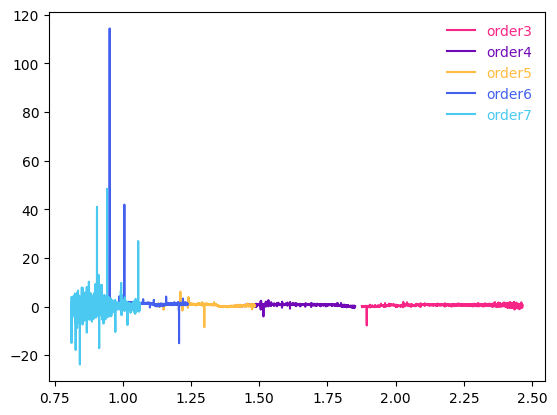

In [195]:
# obs0004 = sequence(xb_data[0:4], save=True, name='obs0004')
obs0 = sequence(xb_data[0:4])

for i, order in enumerate(np.arange(3, 8)):
    plt.plot(*obs0004[order], c=cc[i], label=f'order{order}')
plt.legend(frameon=False, labelcolor='linecolor')
plt.show()

/tmp/ipykernel_27060/419647787.py:32: RuntimeWarning: divide by zero encountered in true_divide
  im /= f


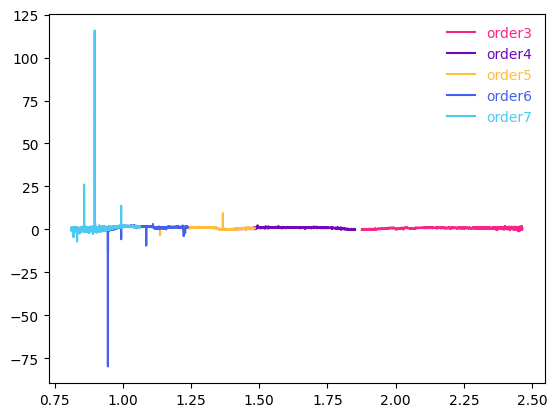

In [196]:
# obs0408 = sequence(xb_data[4:8], save=True, name='obs0408')
obs1 = sequence(xb_data[4:8])

for i, order in enumerate(np.arange(3, 8)):
    plt.plot(*obs0408[order], c=cc[i], label=f'order{order}')
plt.legend(frameon=False, labelcolor='linecolor')
plt.show()

/tmp/ipykernel_27060/419647787.py:32: RuntimeWarning: divide by zero encountered in true_divide
  im /= f


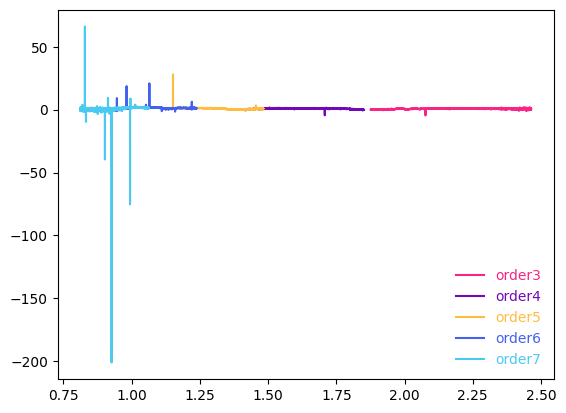

In [197]:
# obs0812 = sequence(xb_data[8:12], save=True, name='obs0812')
obs2 = sequence(xb_data[8:12])

for i, order in enumerate(np.arange(3, 8)):
    plt.plot(*obs0812[order], c=cc[i], label=f'order{order}')
plt.legend(frameon=False, labelcolor='linecolor')
plt.show()

/tmp/ipykernel_27060/419647787.py:32: RuntimeWarning: divide by zero encountered in true_divide
  im /= f


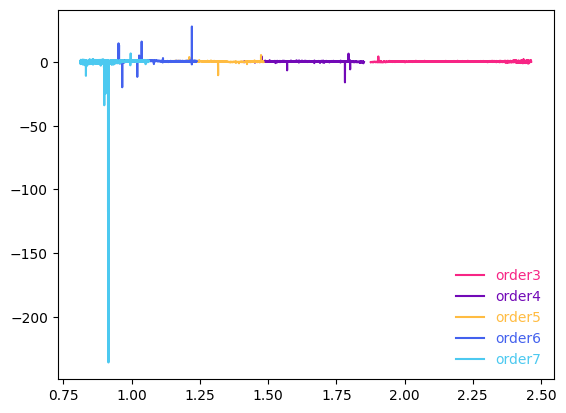

In [198]:
# obs1216 = sequence(xb_data[12:16], save=True, name='obs1216')
obs3 = sequence(xb_data[12:16])

for i, order in enumerate(np.arange(3, 8)):
    plt.plot(*obs1216[order], c=cc[i], label=f'order{order}')
plt.legend(frameon=False, labelcolor='linecolor')
plt.show()

# Get the spectra for standard star observations

/tmp/ipykernel_27060/419647787.py:32: RuntimeWarning: divide by zero encountered in true_divide
  im /= f


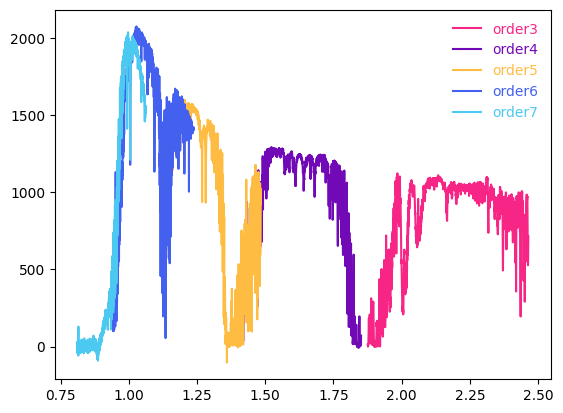

In [31]:
std0 = sequence(standard[0:4])

for i, order in enumerate(np.arange(3, 8)):
    plt.plot(*std0[order], c=cc[i], label=f'order{order}')
plt.legend(frameon=False, labelcolor='linecolor')
plt.show()

/tmp/ipykernel_27060/419647787.py:32: RuntimeWarning: divide by zero encountered in true_divide
  im /= f


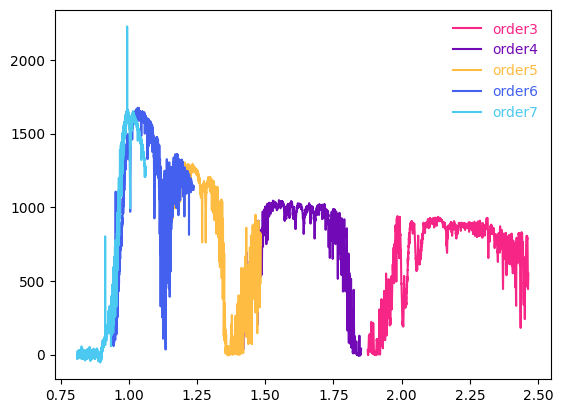

In [32]:
std1 = sequence(standard[4:8])

for i, order in enumerate(np.arange(3, 8)):
    plt.plot(*std1[order], c=cc[i], label=f'order{order}')
plt.legend(frameon=False, labelcolor='linecolor')
plt.show()

/tmp/ipykernel_27060/419647787.py:32: RuntimeWarning: divide by zero encountered in true_divide
  im /= f


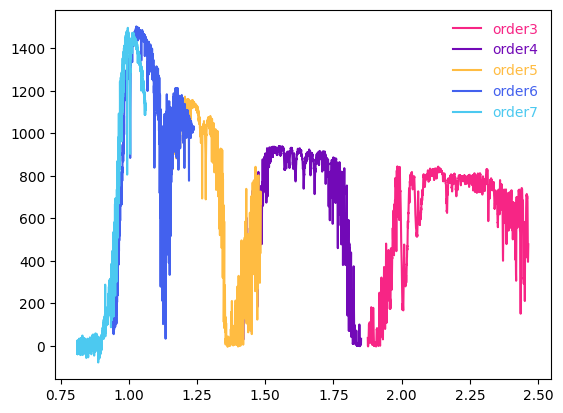

In [33]:
std2 = sequence(standard[8:12])

for i, order in enumerate(np.arange(3, 8)):
    plt.plot(*std2[order], c=cc[i], label=f'order{order}')
plt.legend(frameon=False, labelcolor='linecolor')
plt.show()

# Construct calibration spectrum

In [99]:
with fits.open('alpha_lyr_mod_004.fits') as hdul:
    header = hdul[0].header
    print(repr(header))
#     star_radius = hdul[0].header['PHXREFF']
    dat = np.array(list(hdul[1].data))
    ref_flux = dat[:,1].astype(float)
    ref_wv = dat[:,0].astype(float)

# # set initial units
ref_flux = ref_flux * u.erg / u.s / u.cm**2 / u.AA
ref_wv *= u.AA
# # convert units
ref_flux = ref_flux.to(u.watt / u.m**2 / u.micron).value
ref_wv = ref_wv.to(u.micron).value

# photon flux in phot s-1 m-2 micron-1
ref_flux_phot = ref_flux / (c.h * c.c / (ref_wv*u.micron.to(u.m))).value

# multiply by mirror area (200 inch diameter), now in units photons s-1 nm-1
ref_flux_phot *= (np.pi * 2.54**2)
# multiply by bin width
ref_flux_phot *= np.array([*np.diff(ref_wv), np.diff(ref_wv)[-1]])

SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T /FITS extensions present?                        
SOURCE  = 'Bohlin, Hubeny, & Rauch 2020, AJ, in press' /                        
SOURCE2 = 'Bohlin, Deustua, & de Rosa 2019, AJ, 158, 211' /                     
COMMENT = 'Created by R. Bohlin from Kurucz Special Model' /                    
TEFFGRAV= '9550/3.95'          /Teff/log g for model                            
DESCRIP = 'MODEL Fluxes ------------------------------------------------------' 
DBTABLE = 'CRSPECTRUM'         /                                                
TARGETID= 'ALPHA_LYR_MOD'      /                                                
MAPKEY  = 'calspec '           /                                                
AIRMASS =              0.000

In [244]:
def get_cal_spec(std_spec, plot=False):
    # spectrograph wavelength solution from standard star data
    wv_sol = std_spec[0]
    # calculate spacing, Δ𝜆/2
    wv_spacing = np.diff(wv_sol)/2
    # calculate edges, 𝜆±Δ𝜆/2
    wv_edges = np.array([wv_sol[0]-wv_spacing[0], *wv_sol[:-1]+wv_spacing, wv_sol[-1]+wv_spacing[-1]])
    # fill in bins with sum of reference flux
    ref_wv_lim = ref_wv[(ref_wv > 0.7)*(ref_wv < 2.5)]
    ref_flux_lim = ref_flux_phot[(ref_wv > 0.7)*(ref_wv < 2.5)]

    wv_bins = np.zeros(len(wv_sol))
    for i, bn in enumerate(wv_bins):
        # sum and multiply by bin width in microns to get flux in units of photons s-1
        wv_bins[i] = np.sum(ref_flux_lim[(ref_wv_lim < wv_edges[i])*(ref_wv_lim > wv_edges[i+1])])
    non0 = (wv_bins > 0)
    f = interp1d(wv_sol[non0], wv_bins[non0], kind='nearest', fill_value='extrapolate')
    wv_bins_interp = f(wv_sol)
    
    # calculate the flux calibration by dividing result by the observed spectrum
    flux_cal = wv_bins_interp / std_spec[1]
    
    if plot:
        plt.plot(wv_sol, flux_cal)
        plt.xlabel('Wavelength [$\mu$m]')
        plt.ylabel('Calibration [photons/counts]')
    
    return flux_cal

def get_cal_dict(std_spec_dict):
    cal_dict = {}
    for order in std_spec_dict:
        cal_dict[order] = get_cal_spec(std_spec_dict[order])
    return cal_dict

In [245]:
cal0 = get_cal_dict(std0)
cal1 = get_cal_dict(std1)
cal2 = get_cal_dict(std2)

# Calibrate science spectra

In [227]:
def calibrate(spec, cal, save=False, name='NAME'):
    # calibrates by multiplying by the calibration spectrum
    cal_spec = {}
    for order in spec:
        cal_spec[order] = [spec[order][0], spec[order][1]*cal[order]]
    # combines all orders into one
    wv = np.array(list(cal_spec.values()))[:,0].flatten()
    flux = np.array(list(cal_spec.values()))[:,1].flatten()
    final = np.array(sorted(zip(wv, flux))).T
    # save final spectrum
    if save:
        np.save(f'./spectra/{name}_final', final)
    return final

In [228]:
final0 = calibrate(obs0, cal0, save=True, name='spec0138')
final1 = calibrate(obs1, cal0, save=True, name='spec0235')
final2 = calibrate(obs2, cal1, save=True, name='spec0258')
final3 = calibrate(obs3, cal2, save=True, name='spec0434')